# Import and/or install libraries: 

In [2]:
import numpy as np
from numpy.fft import fftfreq, fft, ifft, irfft2, rfft2

import seaborn as sns
import matplotlib.pyplot as plt

# Initialize simulation:

In [15]:
def fftn_serial(u, fu, Uc_hatT):
    '''
    Perform forward Fourier transform (serial version)
    '''
    Uc_hatT[:] = rfft2(u, axes=(1, 2))
    fu[:] = Uc_hatT
    fu[:] = fft(fu, axis=0)
    return fu

def IC_3D(U, U_hat, X, Uc_hatT, IC_type):
    '''
    This function initializes the velocity field in Fourier space based on the initial condition type
    '''

    if IC_type == 'random_vel':
        # Random velocity components scaled to match the initial taylor-green vortex energy.

        # Random velocity initial condition
        U[0] = np.random.rand(*X[0].shape) - 0.5
        U[1] = np.random.rand(*X[0].shape) - 0.5
        U[2] = np.random.rand(*X[0].shape) - 0.5

        # Calculate the initial energy of the random velocity field
        taylor_green_initial_energy = 0.5*((2*np.pi)**3)/4
        rand_initial_energy = 0.5 * np.sum(U[0]**2 + U[1]**2 + U[2]**2) * (2 * np.pi / X[0].shape[0])**3
    
        # Scale:
        scaling_factor = np.sqrt(taylor_green_initial_energy/rand_initial_energy)
        U[0] *= scaling_factor
        U[1] *= scaling_factor
        U[2] *= scaling_factor

    if IC_type == 'taylor_green':
        # Taylor-Green vortex initial conditions (Check Mortensen (2016) paper)
        U[0] = np.sin(X[0])*np.cos(X[1])*np.cos(X[2])
        U[1] = -np.cos(X[0])*np.sin(X[1])*np.cos(X[2])
        U[2] = 0

    if IC_type == 'taylor_green_noise':
        # Taylor-Green vortex with added noise initial condition
        U[0] = np.sin(X[0])*np.cos(X[1])*np.cos(X[2])
        U[1] = -np.cos(X[0])*np.sin(X[1])*np.cos(X[2])
        U[2] = 0

        #Add white noise:
        epsilon = 0.1
        U[0] += epsilon*np.random.rand(*U[0].shape)
        U[1] += epsilon*np.random.rand(*U[1].shape)
        U[2] += epsilon*np.random.rand(*U[2].shape)

    if IC_type == 'perlin_noise':
        # Perlin noise initial condition

        scale = 1/4 #0.25
        octaves = 5 #2
        persistence = 0.4 #0.5
        lacunarity = 2 #2

        for i in range(X[0].shape[0]):
            for j in range(X[0].shape[1]):
                for k in range(X[0].shape[2]):
                    noise_value = noise.pnoise3(X[0][i, j, k]*scale,
                                                X[1][i, j, k]*scale,
                                                X[2][i, j, k]*scale,
                                                octaves=octaves,
                                                persistence=persistence,
                                                lacunarity=lacunarity)
                    # A scalar perlin noise field is generated, then, the same values is assign to every velocity component.
                    U[0][i, j, k] = noise_value
                    U[1][i, j, k] = noise_value
                    U[2][i, j, k] = noise_value

    if IC_type == 'abc_flow':
        # ABC flow initialization (Check Rempel (2009) paper)
        amplitude = 1
        forcing_wavenumber = 5 #5 #0.5
        phase_shift = 0 #np.pi/4

        U[0] = amplitude * np.sin(forcing_wavenumber*X[2] + phase_shift) + np.cos(forcing_wavenumber*X[1] + phase_shift)
        U[1] = amplitude * np.sin(forcing_wavenumber*X[0] + phase_shift) + np.cos(forcing_wavenumber*X[2] + phase_shift)
        U[2] = amplitude * np.sin(forcing_wavenumber*X[1] + phase_shift) + np.cos(forcing_wavenumber*X[0] + phase_shift)

    if IC_type == 'zero':
        # Initiate the velocities with 0 norm
        U[0] = 0.0
        U[1] = 0.0
        U[2] = 0.0

    if IC_type == 'linear':
        # Creates a field for plot testing

        # Create a grid of coordinates (x, y, z)
        x = np.linspace(0, 1/3, N)  # Grid values between 0 and 1
        y = np.linspace(0, 1/3, N)
        z = np.linspace(0, 1/3, N)
        X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

        # Compute velocity components
        U[0] = X + Y + Z  # Velocity in the x-direction
        U[1] = X + Y + Z  # Velocity in the y-direction
        U[2] = X + Y + Z  # Velocity in the z-direction

    # On spectral space:
    for i in range(3):
        U_hat[i] = fftn_serial(U[i], U_hat[i], Uc_hatT)

    return U, U_hat

def init_variables():

    size = 1  # Number of MPI processes. One, for this test.
    rank = 0  # MPI rank. Zero, for this test.

    # SIMULATION PARAMETERS:
    viscosity = 1/1600                  # Viscosity = 1/Reynolds. Suggestion: Reynolds -> 1600
    t_f = 20                            # Final physical time
    dt = 0.02                           # Time step. Suggestion: 0.05, 0.15 or 0.01
    N = 2**8                           # Grid dimension
    IC_type = 'taylor_green'            # Initial conditions.
    n_steps = int(np.ceil(t_f/dt))      # Number of frames in the simulation
    every = int(np.ceil(n_steps/10))    # Plot and or calculate "every" iterations:
    n_steps = int(np.ceil(t_f/dt))      # Number of frames in the simulation
    Np = N//size                        # Lenght of the slab

    # Coordinates and wave numbers:
    X = np.mgrid[rank*Np:(rank+1)*Np, :N, :N].astype(float)*2*np.pi/N # 2*pi is the lenght of the physical domain
    kx = fftfreq(N, 1./N)
    kz = kx[:(N//2+1)].copy()
    kz[-1] *= -1
    K = np.array(np.meshgrid(kx, kx[rank*Np:(rank+1)*Np], kz, indexing='ij'), dtype=int)
    K2 = np.sum(K*K, 0, dtype=int)
    K_over_K2 = K.astype(float)/np.where(K2 == 0, 1, K2).astype(float)

    # Define dealias:
    kmax_dealias = 2./3.*(N//2+1)
    dealias = np.array((abs(K[0]) < kmax_dealias)*(abs(K[1]) < kmax_dealias)*
                    (abs(K[2]) < kmax_dealias), dtype=bool)

    # Preallocate arrays
    U = np.empty((3, Np, N, N))
    U_hat = np.zeros((3, N, Np, N//2+1), dtype=complex) # np.empty((3, N, Np, N//2+1), dtype=complex)
    P = np.empty((Np, N, N))
    P_hat = np.empty((N, Np, N//2+1), dtype=complex)
    U_hat0 = np.empty((3, N, Np, N//2+1), dtype=complex)
    U_hat1 = np.empty((3, N, Np, N//2+1), dtype=complex)
    dU = np.empty((3, N, Np, N//2+1), dtype=complex)
    Uc_hat = np.empty((N, Np, N//2+1), dtype=complex)
    Uc_hatT = np.empty((Np, N, N//2+1), dtype=complex) # np.empty((Np, N, N//2+1), dtype=complex)
    curl = np.empty((3, Np, N, N))

    # Runge-Kutta coefficients:
    a = [1./6., 1./3., 1./3., 1./6.]
    b = [0.5, 0.5, 1.]

    # Velocity fields initialization:
    U, U_hat = IC_3D(U, U_hat, X, Uc_hatT, IC_type)

    return U, U_hat


# Calculate timestep based on the CFLs:

## Functions to calculate the timesteps:

In [37]:
def compute_advective_dt(U, dx, target_cfl):
    """
    Compute maximum timestep for given advective CFL condition
    dt = CFL * dx / u_max
    """
    # Compute maximum velocity magnitude
    u_max = np.max(np.sqrt(U[0]**2 + U[1]**2 + U[2]**2))
    
    # Calculate timestep for target CFL
    if u_max > 0:
        dt_max = target_cfl * dx / u_max
    else:
        dt_max = float('inf')  # No velocity, no restriction
    
    return dt_max, u_max

def compute_viscous_dt(viscosity, dx, target_cfl):
    """
    Compute maximum timestep for given viscous CFL condition
    dt = CFL * dx² / viscosity
    """
    # Calculate timestep for target viscous CFL
    dt_max = target_cfl * dx**2 / viscosity
    
    return dt_max

def compute_spectral_dt(U, N, target_cfl, dealiasing_factor=2./3.):
    """
    Compute maximum timestep for spectral CFL with dealiasing accounted
    dt = target_CFL / (k_max_effective * u_max)
    """
    # Effective maximum wavenumber with dealiasing
    k_max_effective = dealiasing_factor * (N // 2)
    
    # Compute maximum velocity magnitude
    u_max = np.max(np.sqrt(U[0]**2 + U[1]**2 + U[2]**2))
    
    # Calculate timestep for target spectral CFL
    if u_max > 0:
        dt_max = target_cfl / (k_max_effective * u_max)
    else:
        dt_max = float('inf')  # No velocity, no restriction
    
    return dt_max, u_max


## Advective CFL:

In [28]:
# Common resolutions for the simulations
list_of_resolutions = [2**1, 2**2, 2**3, 2**4, 2**5, 2**6, 2**7, 2**8, 2**9, 2**10, 2**11, 2**12, 2**13, 2**14, 2**15]
# Based on the NASA workshop solutions:
smaller_CFL = 0.6
bigger_CFL = 1

list_smaller_CFL = []
list_bigger_CFL = []

# Time step computation:
for i in range(len(list_of_resolutions)):

    print('Resolution:', list_of_resolutions[i])

    N_tmp = list_of_resolutions[i]
    dx = 2 * np.pi / N_tmp  # Spatial resolution

    # Initialize variables for this resolution
    U, _ = init_variables()

    # Small CFL
    dt_max, u_max = compute_advective_dt(U, dx, smaller_CFL)
    print("Time step for smaller CFL:", dt_max)
    list_smaller_CFL.append(dt_max)

    # Big CFL
    dt_max, u_max = compute_advective_dt(U, dx, bigger_CFL)
    print("Time step for bigger CFL:", dt_max)
    list_bigger_CFL.append(dt_max)

    print("Max velocity:", u_max)


Resolution: 2
Time step for smaller CFL: 1.8849555921538759
Time step for bigger CFL: 3.141592653589793
Max velocity: 1.0
Resolution: 4
Time step for smaller CFL: 0.9424777960769379
Time step for bigger CFL: 1.5707963267948966
Max velocity: 1.0
Resolution: 8
Time step for smaller CFL: 0.47123889803846897
Time step for bigger CFL: 0.7853981633974483
Max velocity: 1.0
Resolution: 16
Time step for smaller CFL: 0.23561944901923448
Time step for bigger CFL: 0.39269908169872414
Max velocity: 1.0
Resolution: 32
Time step for smaller CFL: 0.11780972450961724
Time step for bigger CFL: 0.19634954084936207
Max velocity: 1.0
Resolution: 64
Time step for smaller CFL: 0.05890486225480862
Time step for bigger CFL: 0.09817477042468103
Max velocity: 1.0
Resolution: 128
Time step for smaller CFL: 0.02945243112740431
Time step for bigger CFL: 0.04908738521234052
Max velocity: 1.0
Resolution: 256
Time step for smaller CFL: 0.014726215563702155
Time step for bigger CFL: 0.02454369260617026
Max velocity: 1.

In [21]:
print(list_smaller_CFL)
print(list_bigger_CFL)

[1.8849555921538759, 0.9424777960769379, 0.47123889803846897, 0.23561944901923448, 0.11780972450961724, 0.05890486225480862, 0.02945243112740431, 0.014726215563702155, 0.007363107781851078, 0.003681553890925539, 0.0018407769454627694, 0.0009203884727313847, 0.00046019423636569235, 0.00023009711818284618, 0.00011504855909142309]
[3.141592653589793, 1.5707963267948966, 0.7853981633974483, 0.39269908169872414, 0.19634954084936207, 0.09817477042468103, 0.04908738521234052, 0.02454369260617026, 0.01227184630308513, 0.006135923151542565, 0.0030679615757712823, 0.0015339807878856412, 0.0007669903939428206, 0.0003834951969714103, 0.00019174759848570515]


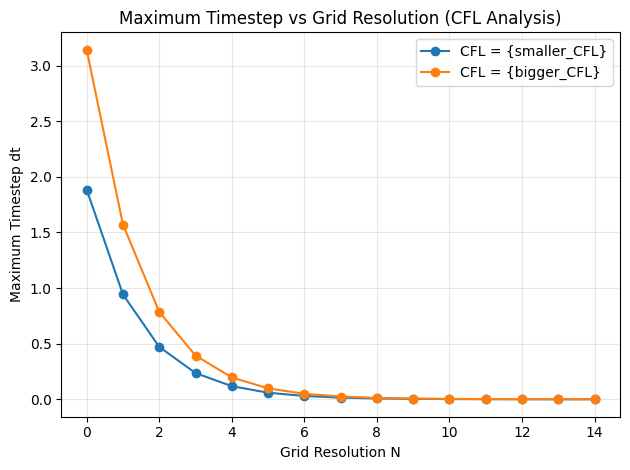

In [27]:
# Plot with log scale
plt.figure(figsize=(6.4, 4.8))

plt.plot(list_smaller_CFL, marker='o', label=r'CFL = {smaller_CFL}')
plt.plot(list_bigger_CFL, marker='o', label=r'CFL = {bigger_CFL}')

plt.xlabel('Grid Resolution N')
plt.ylabel('Maximum Timestep dt')
plt.title('Maximum Timestep vs Grid Resolution (CFL Analysis)')
plt.legend()
plt.grid(True, alpha=0.3)

# Make it look nice
plt.tight_layout()
plt.show()

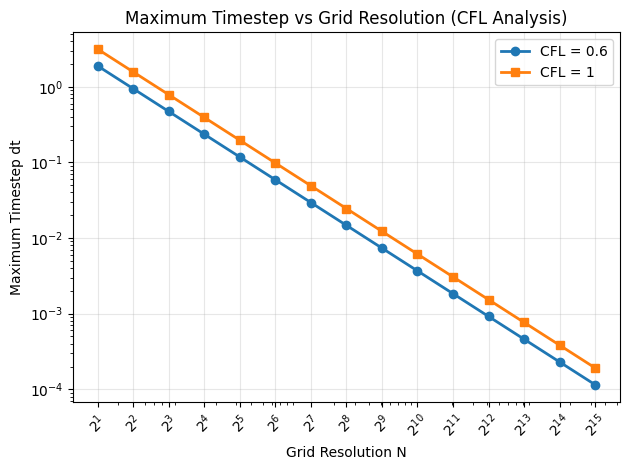

In [25]:
# Plot with log scale
plt.figure(figsize=(6.4, 4.8))

# Plot both CFL curves
plt.loglog(list_of_resolutions, list_smaller_CFL, 'o-', linewidth=2, markersize=6, label=f'CFL = {smaller_CFL}')
plt.loglog(list_of_resolutions, list_bigger_CFL, 's-', linewidth=2, markersize=6, label=f'CFL = {bigger_CFL}')

plt.xlabel('Grid Resolution N')
plt.ylabel('Maximum Timestep dt')
plt.title('Maximum Timestep vs Grid Resolution (CFL Analysis)')
plt.legend()
plt.grid(True, alpha=0.3)

# Set x-axis ticks to show powers of 2
power_labels = [f'$2^{{{int(np.log2(n))}}}$' for n in list_of_resolutions]
plt.xticks(list_of_resolutions, power_labels, rotation=45)

# Make it look nice
plt.tight_layout()
plt.show()

## Diffusion CFL:

In [31]:
# Common resolutions for the simulations
list_of_resolutions = [2**1, 2**2, 2**3, 2**4, 2**5, 2**6, 2**7, 2**8, 2**9, 2**10, 2**11, 2**12, 2**13, 2**14, 2**15]

# Based on the NASA workshop solutions:
smaller_CFL = 0.6
bigger_CFL = 1

list_smaller_CFL = []
list_bigger_CFL = []

# Time step computation:
for i in range(len(list_of_resolutions)):

    print('Resolution:', list_of_resolutions[i])

    N_tmp = list_of_resolutions[i]
    dx = 2 * np.pi / N_tmp  # Spatial resolution
    viscosity = 1/1600

    # Small CFL
    dt_max = compute_viscous_dt(viscosity, dx, smaller_CFL)
    print("Time step for smaller CFL:", dt_max)
    list_smaller_CFL.append(dt_max)

    # Big CFL
    dt_max = compute_viscous_dt(viscosity, dx, bigger_CFL)
    print("Time step for bigger CFL:", dt_max)
    list_bigger_CFL.append(dt_max)


Resolution: 2
Time step for smaller CFL: 9474.820225045783
Time step for bigger CFL: 15791.367041742973
Resolution: 4
Time step for smaller CFL: 2368.705056261446
Time step for bigger CFL: 3947.8417604357433
Resolution: 8
Time step for smaller CFL: 592.1762640653615
Time step for bigger CFL: 986.9604401089358
Resolution: 16
Time step for smaller CFL: 148.04406601634037
Time step for bigger CFL: 246.74011002723395
Resolution: 32
Time step for smaller CFL: 37.01101650408509
Time step for bigger CFL: 61.68502750680849
Resolution: 64
Time step for smaller CFL: 9.252754126021273
Time step for bigger CFL: 15.421256876702122
Resolution: 128
Time step for smaller CFL: 2.3131885315053182
Time step for bigger CFL: 3.8553142191755305
Resolution: 256
Time step for smaller CFL: 0.5782971328763296
Time step for bigger CFL: 0.9638285547938826
Resolution: 512
Time step for smaller CFL: 0.1445742832190824
Time step for bigger CFL: 0.24095713869847066
Resolution: 1024
Time step for smaller CFL: 0.036143

In [32]:
print(list_smaller_CFL)
print(list_bigger_CFL)

[9474.820225045783, 2368.705056261446, 592.1762640653615, 148.04406601634037, 37.01101650408509, 9.252754126021273, 2.3131885315053182, 0.5782971328763296, 0.1445742832190824, 0.0361435708047706, 0.00903589270119265, 0.0022589731752981623, 0.0005647432938245406, 0.00014118582345613515, 3.5296455864033786e-05]
[15791.367041742973, 3947.8417604357433, 986.9604401089358, 246.74011002723395, 61.68502750680849, 15.421256876702122, 3.8553142191755305, 0.9638285547938826, 0.24095713869847066, 0.060239284674617664, 0.015059821168654416, 0.003764955292163604, 0.000941238823040901, 0.00023530970576022525, 5.882742644005631e-05]


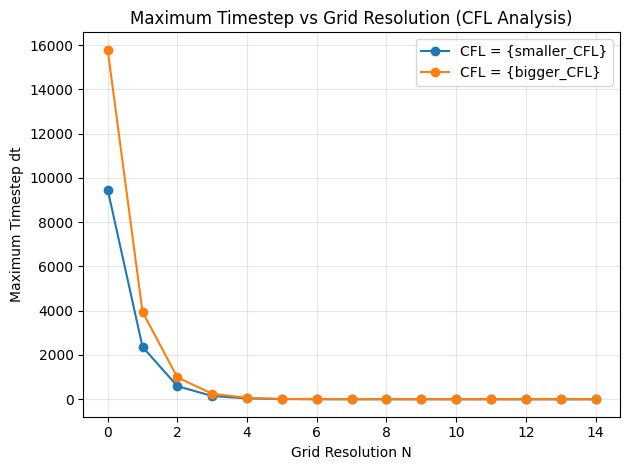

In [33]:
# Plot with log scale
plt.figure(figsize=(6.4, 4.8))

plt.plot(list_smaller_CFL, marker='o', label=r'CFL = {smaller_CFL}')
plt.plot(list_bigger_CFL, marker='o', label=r'CFL = {bigger_CFL}')

plt.xlabel('Grid Resolution N')
plt.ylabel('Maximum Timestep dt')
plt.title('Maximum Timestep vs Grid Resolution (CFL Analysis)')
plt.legend()
plt.grid(True, alpha=0.3)

# Make it look nice
plt.tight_layout()
plt.show()

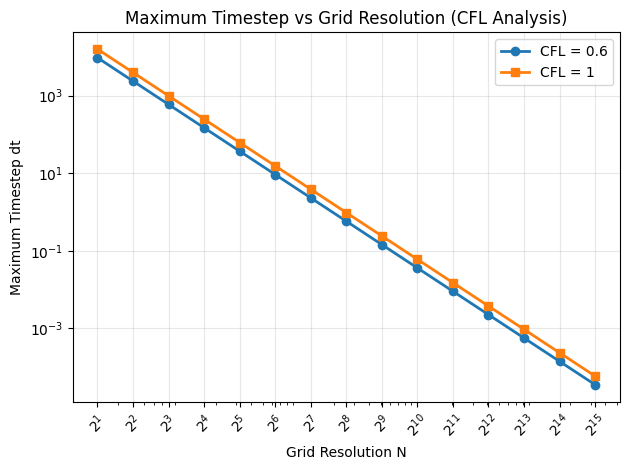

In [34]:
# Plot with log scale
plt.figure(figsize=(6.4, 4.8))

# Plot both CFL curves
plt.loglog(list_of_resolutions, list_smaller_CFL, 'o-', linewidth=2, markersize=6, label=f'CFL = {smaller_CFL}')
plt.loglog(list_of_resolutions, list_bigger_CFL, 's-', linewidth=2, markersize=6, label=f'CFL = {bigger_CFL}')

plt.xlabel('Grid Resolution N')
plt.ylabel('Maximum Timestep dt')
plt.title('Maximum Timestep vs Grid Resolution (CFL Analysis)')
plt.legend()
plt.grid(True, alpha=0.3)

# Set x-axis ticks to show powers of 2
power_labels = [f'$2^{{{int(np.log2(n))}}}$' for n in list_of_resolutions]
plt.xticks(list_of_resolutions, power_labels, rotation=45)

# Make it look nice
plt.tight_layout()
plt.show()

## FFT CFL:

In [38]:
# Common resolutions for the simulations
list_of_resolutions = [2**1, 2**2, 2**3, 2**4, 2**5, 2**6, 2**7, 2**8, 2**9, 2**10, 2**11, 2**12, 2**13, 2**14, 2**15]
# Based on the NASA workshop solutions:
smaller_CFL = 0.6
bigger_CFL = 1

list_smaller_CFL = []
list_bigger_CFL = []

# Time step computation:
for i in range(len(list_of_resolutions)):

    print('Resolution:', list_of_resolutions[i])

    N_tmp = list_of_resolutions[i]
    dx = 2 * np.pi / N_tmp  # Spatial resolution

    # Initialize variables for this resolution
    U, _ = init_variables()

    dt_max, u_max = compute_spectral_dt(U, N_tmp, smaller_CFL)
    print("Time step for smaller CFL:", dt_max)
    list_smaller_CFL.append(dt_max)

    # Big CFL
    dt_max, u_max = compute_spectral_dt(U, N_tmp, bigger_CFL)
    print("Time step for bigger CFL:", dt_max)
    list_bigger_CFL.append(dt_max)

    print("Max velocity:", u_max)


Resolution: 2
Time step for smaller CFL: 0.9
Time step for bigger CFL: 1.5
Max velocity: 1.0
Resolution: 4
Time step for smaller CFL: 0.45
Time step for bigger CFL: 0.75
Max velocity: 1.0
Resolution: 8
Time step for smaller CFL: 0.225
Time step for bigger CFL: 0.375
Max velocity: 1.0
Resolution: 16
Time step for smaller CFL: 0.1125
Time step for bigger CFL: 0.1875
Max velocity: 1.0
Resolution: 32
Time step for smaller CFL: 0.05625
Time step for bigger CFL: 0.09375
Max velocity: 1.0
Resolution: 64
Time step for smaller CFL: 0.028125
Time step for bigger CFL: 0.046875
Max velocity: 1.0
Resolution: 128
Time step for smaller CFL: 0.0140625
Time step for bigger CFL: 0.0234375
Max velocity: 1.0
Resolution: 256
Time step for smaller CFL: 0.00703125
Time step for bigger CFL: 0.01171875
Max velocity: 1.0
Resolution: 512
Time step for smaller CFL: 0.003515625
Time step for bigger CFL: 0.005859375
Max velocity: 1.0
Resolution: 1024
Time step for smaller CFL: 0.0017578125
Time step for bigger CFL:

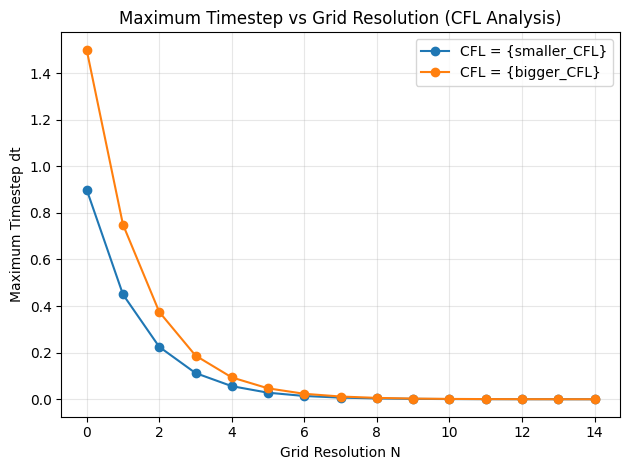

In [45]:
# Plot with log scale
plt.figure(figsize=(6.4, 4.8))

plt.plot(list_smaller_CFL, marker='o', label=r'CFL = {smaller_CFL}')
plt.plot(list_bigger_CFL, marker='o', label=r'CFL = {bigger_CFL}')

plt.xlabel('Grid Resolution N')
plt.ylabel('Maximum Timestep dt')
plt.title('Maximum Timestep vs Grid Resolution (CFL Analysis)')
plt.legend()
plt.grid(True, alpha=0.3)

# Make it look nice
plt.tight_layout()
plt.show()

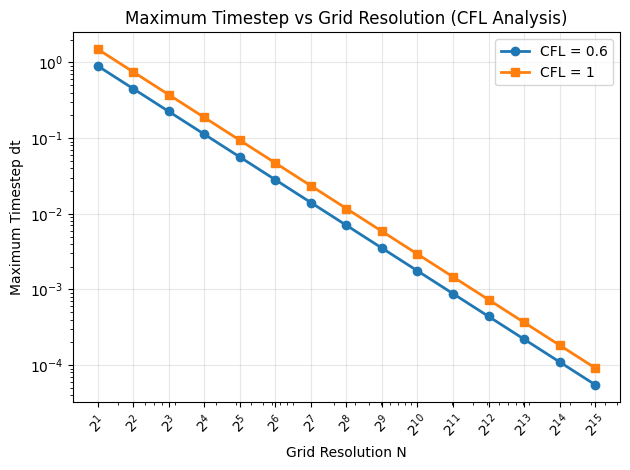

In [46]:
# Plot with log scale
plt.figure(figsize=(6.4, 4.8))

# Plot both CFL curves
plt.loglog(list_of_resolutions, list_smaller_CFL, 'o-', linewidth=2, markersize=6, label=f'CFL = {smaller_CFL}')
plt.loglog(list_of_resolutions, list_bigger_CFL, 's-', linewidth=2, markersize=6, label=f'CFL = {bigger_CFL}')

plt.xlabel('Grid Resolution N')
plt.ylabel('Maximum Timestep dt')
plt.title('Maximum Timestep vs Grid Resolution (CFL Analysis)')
plt.legend()
plt.grid(True, alpha=0.3)

# Set x-axis ticks to show powers of 2
power_labels = [f'$2^{{{int(np.log2(n))}}}$' for n in list_of_resolutions]
plt.xticks(list_of_resolutions, power_labels, rotation=45)

# Make it look nice
plt.tight_layout()
plt.show()

# Plot comparing the values:

## Data:

In [3]:
# Studied resolutions: 
list_of_resolutions = [2**1, 2**2, 2**3, 2**4, 2**5, 2**6, 2**7, 2**8, 2**9, 2**10, 2**11, 2**12, 2**13, 2**14, 2**15]

# Advection CFL
small_advective_CFL = [1.8849555921538759, 0.9424777960769379, 0.47123889803846897, 0.23561944901923448, 0.11780972450961724, 0.05890486225480862, 0.02945243112740431, 0.014726215563702155, 0.007363107781851078, 0.003681553890925539, 0.0018407769454627694, 0.0009203884727313847, 0.00046019423636569235, 0.00023009711818284618, 0.00011504855909142309]
big_advective_CFL = [3.141592653589793, 1.5707963267948966, 0.7853981633974483, 0.39269908169872414, 0.19634954084936207, 0.09817477042468103, 0.04908738521234052, 0.02454369260617026, 0.01227184630308513, 0.006135923151542565, 0.0030679615757712823, 0.0015339807878856412, 0.0007669903939428206, 0.0003834951969714103, 0.00019174759848570515]

# Difusion CFL
small_diffusion_CFL = [9474.820225045783, 2368.705056261446, 592.1762640653615, 148.04406601634037, 37.01101650408509, 9.252754126021273, 2.3131885315053182, 0.5782971328763296, 0.1445742832190824, 0.0361435708047706, 0.00903589270119265, 0.0022589731752981623, 0.0005647432938245406, 0.00014118582345613515, 3.5296455864033786e-05]
big_diffusion_CFL = [15791.367041742973, 3947.8417604357433, 986.9604401089358, 246.74011002723395, 61.68502750680849, 15.421256876702122, 3.8553142191755305, 0.9638285547938826, 0.24095713869847066, 0.060239284674617664, 0.015059821168654416, 0.003764955292163604, 0.000941238823040901, 0.00023530970576022525, 5.882742644005631e-05]

# Spectral CFL
small_fft_CFL = [0.9, 0.45, 0.225, 0.1125, 0.05625, 0.028125, 0.0140625, 0.00703125, 0.003515625, 0.0017578125, 0.00087890625, 0.000439453125, 0.0002197265625, 0.00010986328125, 5.4931640625e-05]
big_fft_CFL = [1.5, 0.75, 0.375, 0.1875, 0.09375, 0.046875, 0.0234375, 0.01171875, 0.005859375, 0.0029296875, 0.00146484375, 0.000732421875, 0.0003662109375, 0.00018310546875, 9.1552734375e-05]


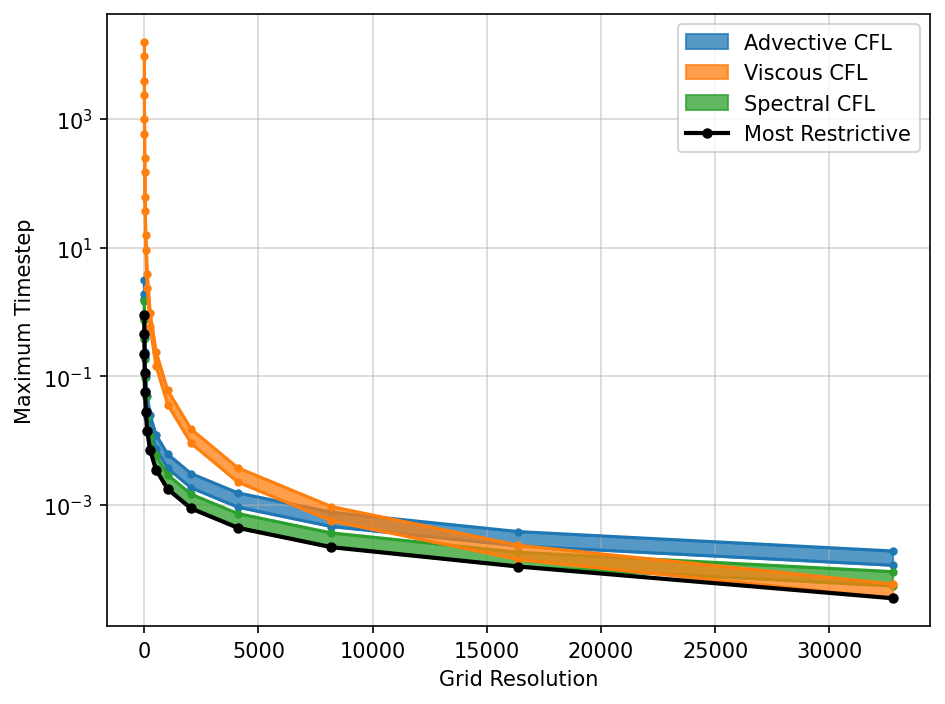

In [43]:
# Plot of linear space:
plt.figure(figsize=(6.4, 4.8), dpi=150)

plt.plot(list_of_resolutions, small_advective_CFL, marker='.', color='C0', zorder=2)
plt.plot(list_of_resolutions, big_advective_CFL, marker='.', color='C0', zorder=2)
plt.fill_between(list_of_resolutions, small_advective_CFL, big_advective_CFL, 
                     alpha=0.75, color='C0', label='Advective CFL', zorder=1)

plt.plot(list_of_resolutions, small_diffusion_CFL, marker='.', color='C1', zorder=6)
plt.plot(list_of_resolutions, big_diffusion_CFL, marker='.', color='C1', zorder=6)
plt.fill_between(list_of_resolutions, small_diffusion_CFL, big_diffusion_CFL, 
                     alpha=0.75, color='C1', label='Viscous CFL', zorder=5)

plt.plot(list_of_resolutions, small_fft_CFL, marker='.', color='C2', zorder=4)
plt.plot(list_of_resolutions, big_fft_CFL, marker='.', color='C2', zorder=4)
plt.fill_between(list_of_resolutions, small_fft_CFL, big_fft_CFL, 
                     alpha=0.75, color='C2', label='Spectral CFL', zorder=3)


# Calculate combined minimum CFL (most restrictive)
combined_min_cfl = [min(adv, visc, spec) for adv, visc, spec in 
                    zip(small_advective_CFL, small_diffusion_CFL, small_fft_CFL)]

# Plot black line for combined minimum
plt.plot(list_of_resolutions, combined_min_cfl, 'k-', linewidth=2, 
         marker='o', markersize=4, label='Most Restrictive', zorder=10)

# Set log-log scale
#plt.xscale('log')
plt.yscale('log')

plt.xlabel('Grid Resolution')
plt.ylabel('Maximum Timestep')
plt.legend()

# Powers of 2 on x-axis
#power_labels = [f'$2^{{{int(np.log2(n))}}}$' for n in list_of_resolutions]
#plt.xticks(list_of_resolutions, power_labels, rotation=45)

plt.tight_layout()
plt.grid(alpha=0.5)
plt.show()

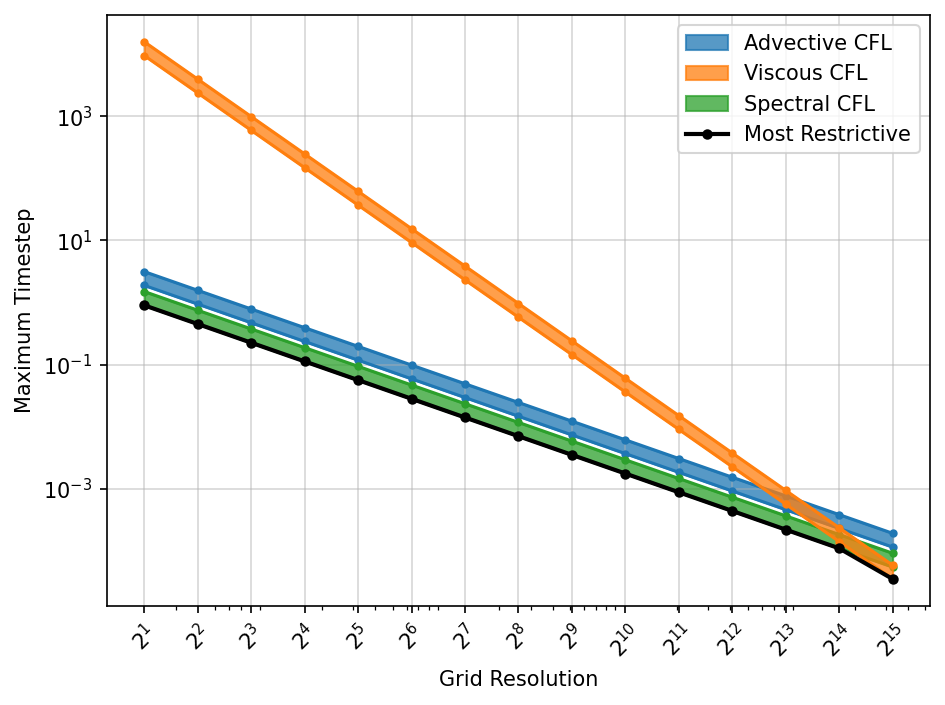

In [44]:
# Plot of linear space:
plt.figure(figsize=(6.4, 4.8), dpi=150)

plt.plot(list_of_resolutions, small_advective_CFL, marker='.', color='C0', zorder=2)
plt.plot(list_of_resolutions, big_advective_CFL, marker='.', color='C0', zorder=2)
plt.fill_between(list_of_resolutions, small_advective_CFL, big_advective_CFL, 
                     alpha=0.75, color='C0', label='Advective CFL', zorder=1)

plt.plot(list_of_resolutions, small_diffusion_CFL, marker='.', color='C1', zorder=6)
plt.plot(list_of_resolutions, big_diffusion_CFL, marker='.', color='C1', zorder=6)
plt.fill_between(list_of_resolutions, small_diffusion_CFL, big_diffusion_CFL, 
                     alpha=0.75, color='C1', label='Viscous CFL', zorder=5)

plt.plot(list_of_resolutions, small_fft_CFL, marker='.', color='C2', zorder=4)
plt.plot(list_of_resolutions, big_fft_CFL, marker='.', color='C2', zorder=4)
plt.fill_between(list_of_resolutions, small_fft_CFL, big_fft_CFL, 
                     alpha=0.75, color='C2', label='Spectral CFL', zorder=3)


# Calculate combined minimum CFL (most restrictive)
combined_min_cfl = [min(adv, visc, spec) for adv, visc, spec in 
                    zip(small_advective_CFL, small_diffusion_CFL, small_fft_CFL)]

# Plot black line for combined minimum
plt.plot(list_of_resolutions, combined_min_cfl, 'k-', linewidth=2, 
         marker='o', markersize=4, label='Most Restrictive', zorder=10)

# Set log-log scale
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Grid Resolution')
plt.ylabel('Maximum Timestep')
plt.legend()

# Powers of 2 on x-axis
power_labels = [f'$2^{{{int(np.log2(n))}}}$' for n in list_of_resolutions]
plt.xticks(list_of_resolutions, power_labels, rotation=45)

plt.tight_layout()
plt.grid(alpha=0.5)
plt.show()

In [ ]:
TODO: ESSE VALOR AQUI PRA 256 É UM OTIMO PARAMETRO PRA COMPARAR AS SIMULAÇÕES. PQ DUAS GPUS FEZ O TEMPO CAIR PELA METADE!

In [27]:
combined_min_cfl

[0.9,
 0.45,
 0.225,
 0.1125,
 0.05625,
 0.028125,
 0.0140625,
 0.00703125,
 0.003515625,
 0.0017578125,
 0.00087890625,
 0.000439453125,
 0.0002197265625,
 0.00010986328125,
 3.5296455864033786e-05]